# Teletrasporto Quantistico

Roberto Garbarino

## Indice

1) [Cos'è il Teletrasporto Quantistico](#what)  

2) [Creare uno Stato Arbitrario](#state)  

3) [Let's Code!](#code)

## Cos'è il Teletrasporto Quantistico? <a name='what'> </a>

Il Teletrasporto Quantistico è una procedura che permette di trasportare un Qubit di informazione fra due parti senza modificarlo o misurarlo.

Supponiamo che Alice ($A$) voglia inviare un qubit di informazione $|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$ a Bob ($B$). Essi dovranno condividere uno stato entangled del tipo:

$$ |\beta_{00}\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}$$

Accoppiamo questo stato entangled a $|\psi\rangle$ :

$$ |\psi_0\rangle = |\psi\rangle|\beta_{00}\rangle = \frac{1}{\sqrt{2}}\left[\alpha|0\rangle(|00\rangle+|11\rangle) + \beta|1\rangle(|00\rangle + |11\rangle)\right]$$

Dove i primi due qubit appartengono ad Alice mentre l'ultimo a Bob.  
Alice ha adesso a disposizione due qubit ed applica ad essi la porta $CNOT$ usando il primo qubit come controllo:

$$
    |\psi_1\rangle = \frac{1}{\sqrt{2}} \left[\alpha|0\rangle\left(|00\rangle + |11\rangle\right) + \beta|1\rangle(|10\rangle|01\rangle)\right]
$$

Alice ora applica una porta $H$ e riscriviamo lo stato risultante separando il qubit che appartiene a Bob (il terzo) da quelli che appartengono ad Alice:

$$
 |\psi_2\rangle = \frac{1}{2} \left[  |00\rangle (\alpha|0\rangle + \beta|1\rangle) + |01\rangle(\alpha|1\rangle + \beta|0\rangle) + |10\rangle(\alpha|0\rangle - \beta|1\rangle) + |11\rangle (\alpha|1\rangle - \beta|0\rangle) \right]
$$

Effettuando una misura del qubit di Bob avremo quindi 4 possibili risultati, ma in realtà soltanto lo stato $\alpha|0\rangle + \beta|1\rangle$ associato a $|00\rangle$ è quello che Alice aveva mandato. L'ultimo passo è quello di aggiustare i risultati di Bob, cosa fattibile misurando i due qubit di Alice.
Vediamo i possibili risultati:

$$
    A : 00 \rightarrow B : \alpha|0\rangle + \beta|1\rangle 
    $$
    $$
    A : 01 \rightarrow B : \alpha|1\rangle + \beta|0\rangle 
    $$
    $$
    A : 10 \rightarrow B : \alpha|0\rangle - \beta|1\rangle 
    $$
    $$
    A : 11 \rightarrow B : \alpha|1\rangle - \beta|0\rangle
    $$

Bob misurerà quindi l'informazione giusta solo per il 25% delle volte; dobbiamo comunicare la misura di $A$ a $B$ e applicare un operatore correttivo in ogni differente caso:

$$
    A : 00 \rightarrow B : \alpha|0\rangle + \beta|1\rangle \\
    A : 01 \rightarrow B : X(\alpha|1\rangle + \beta|0\rangle) = \alpha|0\rangle + \beta|1\rangle \\
    A : 10 \rightarrow B : Z(\alpha|0\rangle - \beta|1\rangle) = \alpha|0\rangle + \beta|1\rangle\\
    A : 11 \rightarrow B : XZ(\alpha|1\rangle - \beta|0\rangle) = \alpha|0\rangle + \beta|1\rangle
$$

## Creare uno Stato Arbitrario<a name='state'> </a>

Iniziamo spiegando come creare uno stato con fasi arbitrarie con Qiskit.

Per fare ciò possiamo semplicemente rotare il nostro stato sull'asse delle y.
Vogliamo inizializzare lo stato $|\psi\rangle = \alpha|0\rangle+\beta|1\rangle$, ovvero dare dei valori concreti ad $\alpha$ e $\beta$. 

Definiamo una nuova funzione `init` con 3 parametri: il circuito su cui lavorare, il qubit da inizializzare e l'alpha$^2$ desiderata, ovvero la probabilità di misurare $|0\rangle$. Questa funzione risolve la seguente equazione rispetto a $\theta$:

$$\cos {\frac{\theta}{2}} = \sqrt{\alpha }.$$

e fa rotare il qubit sull'asse y per lo stesso angolo $\theta$.


In [1]:
##Usual imports
from qiskit import *

#initialization
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy

# import plot tools
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector

from qiskit.visualization import plot_bloch_vector

In [2]:
def init(circuit, qubit, alpha):
    if alpha < 0 or alpha > 1: 
         raise Exception('alpha must be between 0 and 1. The value of alpha was: {}'.format(alpha))
    theta = np.arccos(np.sqrt(float(alpha)))*2
    circuit.ry(theta, qubit)

Proviamo questa funzione creando lo stato $|\psi\rangle = \alpha|0\rangle+\beta|1\rangle$  con $\alpha = \sqrt{0.9}$ e $\beta = \sqrt{0.1}$

In [3]:
qr = QuantumRegister(1)
cr = ClassicalRegister(1)
stateInit = QuantumCircuit(qr,cr)

init(stateInit ,qr[0], 0.9)

Visualizziamolo sulla sfera di Bloch

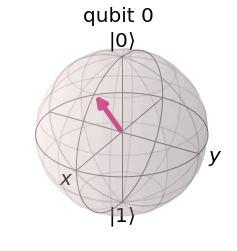

In [4]:
backend = BasicAer.get_backend('statevector_simulator')
result = execute(stateInit, backend).result()
datas  = result.get_statevector(stateInit)

plot_bloch_multivector(datas)

In [5]:
stateInit.measure(0,0)

Testiamolo su un simulatore. Se fosse corretto misureremmo lo stato $|0\rangle$ il 90% delle volte e lo stato  $|1\rangle$ il rimanente 10%.

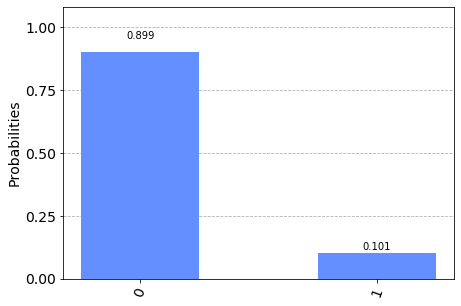

In [21]:
# use local simulator
backend = BasicAer.get_backend('qasm_simulator')
shots = 4096
results = execute(stateInit, backend=backend, shots=shots).result()
data = results.get_counts()
plot_histogram(data)

Tutto sembra a posto.  
Proviamo la stessa funzione su un vero computer quantistico:

In [7]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits > 1 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

C:\Users\Roberto\Anaconda3\lib\site-packages\qiskit\providers\models\backendconfiguration.py:337: UserWarning: `dt` and `dtm` now have units of seconds(s) rather than nanoseconds(ns).
  warnings.warn('`dt` and `dtm` now have units of seconds(s) rather '


least busy backend:  ibmq_essex


In [8]:
from qiskit.tools.monitor import job_monitor

shots = 1024
job = execute(stateInit, backend=backend, shots=shots)

job_monitor(job, interval = 2)

Job Status: job has successfully run


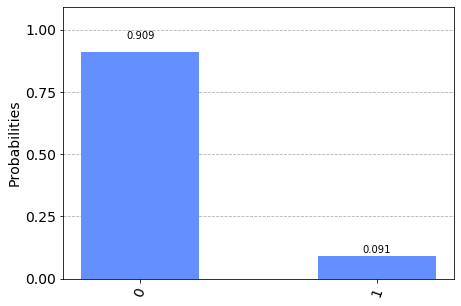

In [9]:
data = job.result()
        
plot_histogram(data.get_counts())

Funziona!

## Let's Code! <a name='code'></a>
  

Lo step 0 è quello di creare il circuito con i registri quantistici che ci servono (3) e i relativi registri classici per effettuare le misure.

In [10]:
qr1 = QuantumRegister(3)
cr0 = ClassicalRegister(1)
cr1 = ClassicalRegister(1)
cr2 = ClassicalRegister(1)

quantumTeleportation = QuantumCircuit(qr1, cr0, cr1, cr2)

Adesso inizializziamo lo stato $|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$ con $\left |  \alpha \right |^2 = 0.9$ e $\left |  \beta \right |^2 = 0.1$ utilizzando la funzione che abbiamo precedentemente dichiarato.
Dopodichè creiamo lo stato entangled di Bell applicando prima una porta $H$ e poi una porta $CNOT$.

In [11]:
##Step 1: building the state |ψ> = sqrt(0.9)|0>+ sqrt(0.1)|1> 
init(quantumTeleportation, qr1[0], 0.9)
quantumTeleportation.barrier()

##Step 2: Creating the Bell State
quantumTeleportation.h(qr1[1])
quantumTeleportation.cx(qr1[1], qr1[2])

quantumTeleportation.cx(qr1[0], qr1[1])
quantumTeleportation.h(qr1[0])
quantumTeleportation.barrier()

Alice misura ora i suoi due qubit e a seconda di queste misura B applica o una porta X o una Z o entrambe al suo stato

In [12]:
##Step 3: Alice now measure her two qubits
quantumTeleportation.measure(qr1[0], cr0)
quantumTeleportation.measure(qr1[1], cr1)

##Step 4: Depending on the results of these measurements, Bob has to apply an X or Z, or both, to his quantum state
quantumTeleportation.cx(qr1[1], qr1[2])
quantumTeleportation.cz(qr1[0], qr1[2])
quantumTeleportation.barrier()

In [13]:
##Step 5: Bob state is now the same as Alice
quantumTeleportation.measure(qr1[2], cr2)

Il circuito è adesso completo. Possiamo disegnarlo per visualizzarlo meglio.

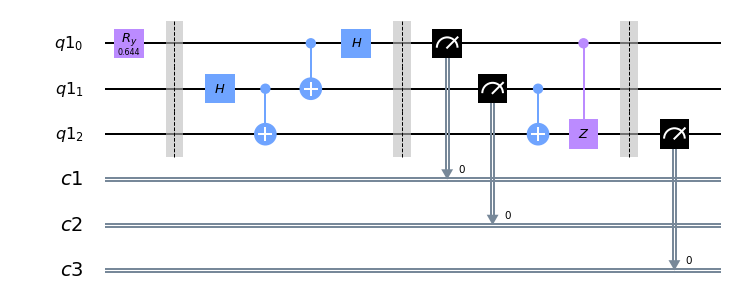

In [14]:
#draw the circuit
quantumTeleportation.draw(output='mpl')

Facciamo girare il nostro circuito sul simulatore.  
I dati risultanti hanno bisogno di un po' di manipolazione; questo perchè abbiamo misurato 3 qubit, e ci darà quindi tutte le combinazioni di queste tre misurazioni. A noi però interessano due gruppi di di qubit: quelli di Alice (il primo e il secondo) e quello di Bob (l'ultimo).

In [15]:
# use local simulator
backend = BasicAer.get_backend('qasm_simulator')
shots = 4096
results = execute(quantumTeleportation, backend=backend, shots=shots).result()
data = results.get_counts()

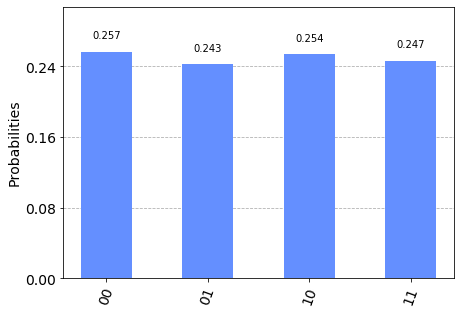

In [16]:
alice = {}
alice['00'] = data['0 0 0'] + data['1 0 0']
alice['10'] = data['0 1 0'] + data['1 1 0']
alice['01'] = data['0 0 1'] + data['1 0 1']
alice['11'] = data['0 1 1'] + data['1 1 1']
plot_histogram(alice)

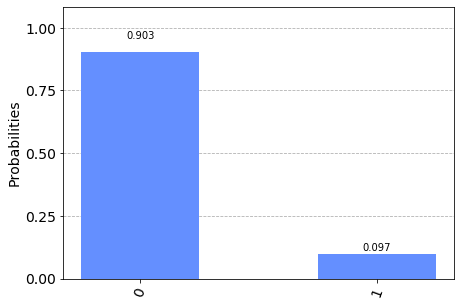

In [17]:
bob = {}
bob['0'] = data['0 0 0'] + data['0 1 0'] +  data['0 0 1'] + data['0 1 1']
bob['1'] = data['1 0 0'] + data['1 1 0'] +  data['1 0 1'] + data['1 1 1']
plot_histogram(bob)

Ripetiamo lo stesso esperimento con uno stato in cui $|\alpha|^2 = 0.3$ e $|\beta|^2 = 0.7$.

In [18]:
qr1 = QuantumRegister(3)
cr0 = ClassicalRegister(1)
cr1 = ClassicalRegister(1)
cr2 = ClassicalRegister(1)

quantumTeleportation = QuantumCircuit(qr1, cr0, cr1, cr2)

##Step 1: building the state |ψ> = sqrt(0.3)|0>+ sqrt(0.7)|1> 
init(quantumTeleportation, qr1[0], 0.3)
quantumTeleportation.barrier()

##Step 2: Creating the Bell State
quantumTeleportation.h(qr1[1])
quantumTeleportation.cx(qr1[1], qr1[2])

quantumTeleportation.cx(qr1[0], qr1[1])
quantumTeleportation.h(qr1[0])
quantumTeleportation.barrier()

##Step 3: Alice now measure her two qubits
quantumTeleportation.measure(qr1[0], cr0)
quantumTeleportation.measure(qr1[1], cr1)

##Step 4: Depending on the results of these measurements, Bob has to apply an X or Z, or both, to his quantum state
quantumTeleportation.cx(qr1[1], qr1[2])
quantumTeleportation.cz(qr1[0], qr1[2])
quantumTeleportation.barrier()

##Step 5: Bob state is now the same as Alice
quantumTeleportation.measure(qr1[2], cr2)

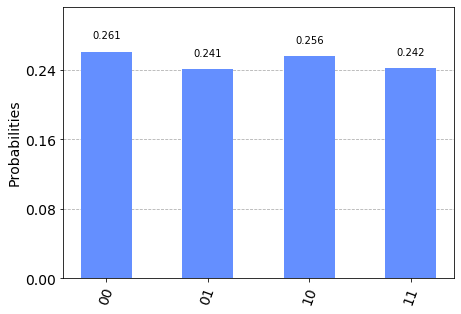

In [19]:
# use local simulator
backend = BasicAer.get_backend('qasm_simulator')
shots = 4096
results = execute(quantumTeleportation, backend=backend, shots=shots).result()
data = results.get_counts()
alice = {}
alice['00'] = data['0 0 0'] + data['1 0 0']
alice['10'] = data['0 1 0'] + data['1 1 0']
alice['01'] = data['0 0 1'] + data['1 0 1']
alice['11'] = data['0 1 1'] + data['1 1 1']
plot_histogram(alice)

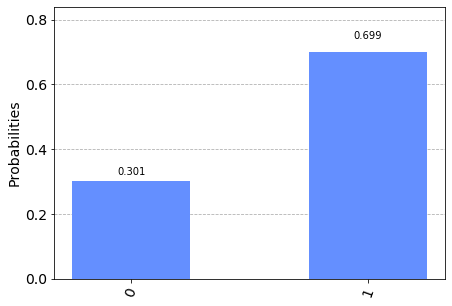

In [20]:
bob = {}
bob['0'] = data['0 0 0'] + data['0 1 0'] +  data['0 0 1'] + data['0 1 1']
bob['1'] = data['1 0 0'] + data['1 1 0'] +  data['1 0 1'] + data['1 1 1']
plot_histogram(bob)